# 1. Đọc dataframe

In [2]:
import os
import json
import pandas as pd

folder_paths = {
    'data/raw/fake': 'Fake',
    'data/raw/real': 'Real'
    }

dfs = [] 

for relative_path, label in folder_paths.items():
    folder_path = os.path.join(os.getcwd(), relative_path)  # Đường dẫn thư mục
    json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]  # Lọc file JSON

    for file in json_files:
        file_path = os.path.join(folder_path, file)  # Đường dẫn file JSON
        
        try:
            # Đọc file JSON
            with open(file_path, "r", encoding="utf-8") as f:
                data = json.load(f)

            # Nếu JSON là dictionary thay vì danh sách, chuyển thành danh sách
            if isinstance(data, dict):
                data = [data]

            # Chuyển đổi thành DataFrame
            df = pd.DataFrame(data)

            # Kiểm tra nếu DataFrame không có dòng nào
            if df.shape[0] == 0:
                print(f"File {file} không có dữ liệu.")
                continue

            # Trích xuất ID từ tên file (Fake_68, Real_15, ...)
            file_parts = file.split("_")  # Tách chuỗi theo dấu "_"
            file_id = "_".join(file_parts[-2:]).replace(".json", "")  # Lấy phần cuối của tên file
            
            # Thống nhất maintext và text thành maintext
            if "text" in df.columns:
                df.rename(columns={"text": "maintext"}, inplace=True)
            if "maintext" not in df.columns:  
                df["maintext"] = ""  # Nếu không có cả 2, đặt giá trị rỗng

            # Kiểm tra và xử lý cột "authors"
            if "authors" in df.columns:
                df["authors"] = df["authors"].apply(lambda x: ", ".join(x) if isinstance(x, list) and len(x) > 0 else "")

            # Thêm cột ID và target (Fake/Real)
            df['id'] = file_id  
            df['target'] = label  

            dfs.append(df)

        except Exception as e:
            print(f"Lỗi khi đọc file {file}: {e}")

# Gộp tất cả DataFrame lại (giữ tất cả cột)
df = pd.concat(dfs, ignore_index=True, join='outer')

# Điền giá trị trống bằng chuỗi rỗng
df = df.fillna('')

# Reset index
df.reset_index(drop=True, inplace=True)


In [3]:
df = df[['id', 'authors', 'source_domain', 'language', 'title', 'description', 'maintext', 'target']]
df.reset_index(drop=True, inplace=True)
df.head()

,id,authors,source_domain,language,title,description,maintext,target
0,Fake_0,,2sao.vn,vi,Con gái chính là người tình kiếp trước của cha...,Tình phụ tử: Cách yêu thương của cha giành cho...,"Thế nhưng, dù không nói ra thì cha vĩnh viễn l...",Fake
1,Fake_1,Văn Trình,binhluan.biz,en,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,,"Theo Sankei Sports, sáng nay Thủ tướng Nhật Bả...",Fake
2,Fake_10,,suckhoe.vnexpress.net,vi,Bức vẽ giúp bạn đánh giá mức độ stress của bản...,Bức vẽ gồm một hình cầu dường như đang trượt m...,"Nhìn bức tranh, bạn có thể thấy vòng tròn đang...",Fake
3,Fake_100,,www.vietgiaitri.com,vi,YÊU RÂU XANH (P51): Câu chuyện động trời sau t...,"Đúng lúc đó, một người hàng xóm nhà bà H sang ...","Sau khi vụ án xảy ra, tất cả mọi người đều khô...",Fake
4,Fake_101,,mangxahoi.net,vi,"NÓNG : xử phạt 10 đối tượng ""bom"" hàng "" Lợi d...",,"ĐANG RẤT QUÁ TẢI, MONG MỌI NGƯỜI Ý THỨC! NGƯỜI...",Fake


In [4]:
df.shape

(260, 8)

# 2. Tiền xử lí dữ liệu

In [5]:
df.describe()

,id,authors,source_domain,language,title,description,maintext,target
count,260,260,260,260,260,260,260,260
unique,260,32,54,3,258,226,259,2
top,Fake_0,,vnexpress.net,vi,Những dấu hiệu nhận biết nhà bạn đang có ma và...,,Những dấu hiệu nhận biết nhà có ma đơn giản nh...,Fake
freq,1,209,74,233,2,34,2,132


Thuộc tính Language có quá ít giá trị (vi, en, rỗng) so với các thuộc tính khác, vì vậy language sẽ không đóng vai trò nhiều trong decision tree.

In [6]:
# Kiểm tra duplicates
df[df.duplicated(subset=df.columns.difference(['id']), keep=False)]


,id,authors,source_domain,language,title,description,maintext,target
69,Fake_42,,tinvn.info,vi,Những dấu hiệu nhận biết nhà bạn đang có ma và...,Những dấu hiệu nhận biết nhà bạn đang có ma và...,Những dấu hiệu nhận biết nhà có ma đơn giản nh...,Fake
105,Fake_75,,tinvn.info,vi,Những dấu hiệu nhận biết nhà bạn đang có ma và...,Những dấu hiệu nhận biết nhà bạn đang có ma và...,Những dấu hiệu nhận biết nhà có ma đơn giản nh...,Fake


In [7]:
df.drop(index=105, inplace=True)  # Xóa dòng có index = 105
df.reset_index(drop=True, inplace=True)  # Reset index, bỏ index cũ


In [8]:
df['target'].value_counts()  # Tỉ lệ giữa Fake và Real xấp xỉ nhau nên dataset này đã cân bằng (balance)

target
Fake    131
Real    128
Name: count, dtype: int64

# 3. Tìm rule-based system 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Thiết kế mô hình cho Decision tree theo tiêu chuẩn entropy
def model_tree(depth):
    model = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=42) 
    return model


# Tính accuracy của Decision tree
def calculate_acc(dataframe, x_features, y_feature, model=model_tree):  
    # Gán X là tập các biến độc lập và y là biến phụ thuộc (biến dự đoán)    
    X = x_features
    y = dataframe[y_feature].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Lấy 80% - 20% dataset để train - test

    # Huấn luyện mô hình
    model.fit(X_train, y_train)

    # Tính acc
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return f"Accuracy của Decision Tree: {accuracy:.2%}"


# Biểu diễn Tree
def plot_decision_tree(model, x_features):
    plt.figure(figsize=(12, 8))
    plot_tree(model, feature_names=x_features, class_names=["Fake", "Real"], filled=True)
    plt.show()


## 3.1 Tìm RB dựa trên `source_domain` và `authors`

In [10]:
df1 = df[['authors', 'source_domain', 'target']]
df1.shape

(259, 3)

In [11]:
# Chuyển đổi 'source_domain' và 'authors' thành số (dùng LabelEncoder)
from sklearn.preprocessing import LabelEncoder

encoder_source = LabelEncoder()
encoder_authors = LabelEncoder()

df1["source_domain_encoded"] = encoder_source.fit_transform(df1["source_domain"])
df1["authors_encoded"] = encoder_authors.fit_transform(df1["authors"])


C:\Users\nttm\AppData\Local\Temp\ipykernel_26688\1272835352.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["source_domain_encoded"] = encoder_source.fit_transform(df1["source_domain"])
C:\Users\nttm\AppData\Local\Temp\ipykernel_26688\1272835352.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["authors_encoded"] = encoder_authors.fit_transform(df1["authors"])


Accuracy của Decision Tree: 90.38%


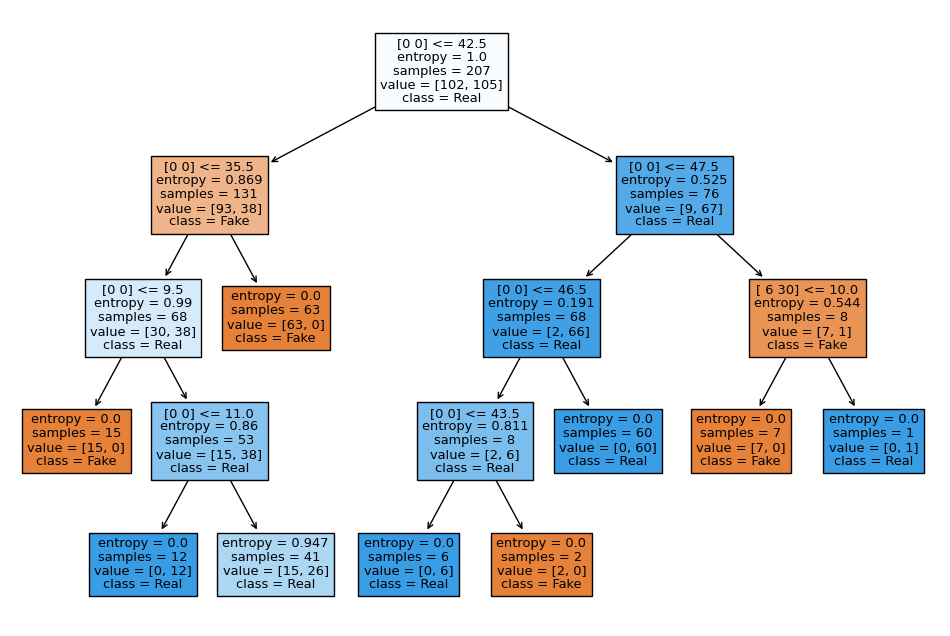

None


In [12]:
tree_model1 = model_tree(depth=4)

X_le = np.hstack([df1["source_domain_encoded"].values.reshape(-1, 1),
                  df1["authors_encoded"].values.reshape(-1, 1)])

print(calculate_acc(df1, X_le, 'target', model=tree_model1))
print(plot_decision_tree(tree_model1, X_le))


In [13]:
# Tạo bảng mapping cho source_domain
df_mapping_source = pd.DataFrame({"source_domain_encoded": df1["source_domain_encoded"],
                                  "source_domain_original": df["source_domain"]}
                                  ).drop_duplicates().sort_values(by="source_domain_encoded", ascending=True)
df_mapping_source


,source_domain_encoded,source_domain_original
0,0,2sao.vn
5,1,anninh247.xyz
35,2,autoxe.net
43,3,baoangiang.com.vn
52,4,baonuocmy.com
11,5,baophapluat.online
1,6,binhluan.biz
29,7,blogxcy.wordpress.com
6,8,cand.com.vn
36,9,congtintuc24gio.com


In [14]:
df[df['source_domain'].str.contains('giadinhtiepthi.com', case=False, na=False)]


,id,authors,source_domain,language,title,description,maintext,target
88,Fake_6,Please Enter Your Name Here,giadinhtiepthi.com,vi,"Cười vỡ bụng khi tiếng CẢI CÁCH ""vuông tròn"" x...",,"Những ngày qua, các phụ huynh liên tục chia sẻ...",Fake
99,Fake_7,Please Enter Your Name Here,giadinhtiepthi.com,vi,Chia sẻ thẳng thắn vụ việc 25000 USD và cải cá...,,"Những ngày qua, trên mạng xã hội các phụ huynh...",Fake


In [15]:
# Tạo bảng mapping cho authors
df_mapping_authors = pd.DataFrame({"authors_encoded": df1["authors_encoded"], 
                                   "authors_original": df["authors"]}
                                   ).drop_duplicates().sort_values(by="authors_encoded", ascending=True)
df_mapping_authors


,authors_encoded,authors_original
0,0,
171,1,An Bình
173,2,CÔNG TRUNG
42,3,Cùng Tác Giả
44,4,"Cùng Tác Giả, Nguyễn Thiện"
172,5,D.KIM THOA
77,6,Gioi Tre Viet
182,7,Hiếu Công
40,8,"Hoàng Vy Thế Giới Trẻ, - Phuong Thao -, - Dung..."
132,9,Hạ Huyền


## 3.2 Tìm RB dựa trên `title`

In [16]:
df2 = df[['title', 'target']]
df2.shape


(259, 2)

In [17]:
# Đọc danh sách n-grams từ file
def read_ngrams(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        return [line.strip() for line in f.readlines()]

# Đọc danh sách n-gram từ 3 file
dictionaries_path = os.path.join(os.getcwd(), "dictionaries")
bi_grams = read_ngrams(os.path.join(dictionaries_path, "bi_gram.txt"))
tri_grams = read_ngrams(os.path.join(dictionaries_path, "tri_gram.txt"))
four_grams = read_ngrams(os.path.join(dictionaries_path, "four_gram.txt"))

# Tổng hợp danh sách tất cả n-grams
all_ngrams = set(bi_grams + tri_grams + four_grams)

print("Số lượng n-grams:", len(all_ngrams))


Số lượng n-grams: 44800


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Lấy dữ liệu tiêu đề
titles = df2["title"].astype(str).tolist()

# Khởi tạo TfidfVectorizer với danh sách n-grams từ file
vectorizer = TfidfVectorizer(ngram_range=(2, 4), vocabulary=all_ngrams)

# Tính toán TF-IDF
X_tfidf = vectorizer.fit_transform(titles)

# Lấy danh sách từ đặc trưng 
feature_names = vectorizer.get_feature_names_out()
tfidf_scores = np.array(X_tfidf.mean(axis=0)).flatten()

# Chuyển thành DataFrame và xếp trọng số TF-IDF giảm dần
df2_tfidf = pd.DataFrame({'N-gram': feature_names, 'TF-IDF Score': tfidf_scores}).sort_values(by="TF-IDF Score", ascending=False)

# Hiển thị danh sách n-gram và trọng số của chúng
df2_tfidf.head(12)


c:\Users\nttm\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:1380: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


,N-gram,TF-IDF Score
41715,đàn ông,0.020670
29536,sự thật,0.019388
19809,máy bay,0.015833
6173,con gái,0.014489
25289,phát hiện,0.013462
35330,tài xế,0.013058
7047,có thể,0.012658
39717,xã hội,0.012587
1684,báo mộng,0.011783
16058,kinh hoàng,0.010419


In [19]:
# Chọn 10 n-gram có trọng số cao nhất
top_ngrams = df2_tfidf.nlargest(300, 'TF-IDF Score')["N-gram"].tolist()


# Tạo feature matrix từ df2['title']
vectorizer_top = TfidfVectorizer(ngram_range=(2, 4), vocabulary=top_ngrams)
# Vector hóa dữ liệu
X_tfidf_top = vectorizer_top.fit_transform(df2["title"]).toarray()


tree_model2 = model_tree(depth=50)
print(calculate_acc(df2, X_tfidf_top, 'target', model=tree_model2))
# print(plot_decision_tree(tree_model2, vectorizer_top.get_feature_names_out()))
feature_names = vectorizer_top.get_feature_names_out().tolist()
print(export_text(tree_model2, feature_names=feature_names))
# print(export_text(tree_model2, feature_names=vectorizer_top.get_feature_names_out()))

Accuracy của Decision Tree: 75.00%
|--- sự thật <= 0.17
|   |--- con gái <= 0.22
|   |   |--- kinh dị <= 0.25
|   |   |   |--- tài xế <= 0.24
|   |   |   |   |--- bí mật <= 0.25
|   |   |   |   |   |--- đàn ông <= 0.43
|   |   |   |   |   |   |--- tất cả <= 0.18
|   |   |   |   |   |   |   |--- báo mộng <= 0.25
|   |   |   |   |   |   |   |   |--- lý do <= 0.26
|   |   |   |   |   |   |   |   |   |--- cải cách <= 0.28
|   |   |   |   |   |   |   |   |   |   |--- cảnh tượng <= 0.20
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 40
|   |   |   |   |   |   |   |   |   |   |--- cảnh tượng >  0.20
|   |   |   |   |   |   |   |   |   |   |   |--- class: Fake
|   |   |   |   |   |   |   |   |   |--- cải cách >  0.28
|   |   |   |   |   |   |   |   |   |   |--- class: Fake
|   |   |   |   |   |   |   |   |--- lý do >  0.26
|   |   |   |   |   |   |   |   |   |--- class: Fake
|   |   |   |   |   |   |   |--- báo mộng >  0.25
|   |   |   |   |   |   |   |   |--- class

# 4. Tổng hợp rule-based system

In [20]:
import string
import math  

def rule_based_classification(source, author, text_title):
    # Danh sách nguồn tin giả mạo
    fake_sources = {
        '2sao.vn', 'anninh247.xyz', 'autoxe.net', 'baoangiang.com.vn', 'baonuocmy.com', 
        'baophapluat.online', 'binhluan.biz', 'blogxcy.wordpress.com', 'cand.com.vn', 'congtintuc24gio.com',
        'thoibao.de', 'thoibao.today', 'tingame.info', 'tintuconline.com.vn', 'tintucqpvn.net', 
        'tinvn.info', 'trumpandq.blogspot.com', 'tuvanannam.com', 'vietgiaitri.com', 'vinaexpress.com.vn'}

    # Danh sách tác giả đáng ngờ (chỉ cần chứa một trong số các từ này)
    fake_author_keywords = {'An Bình', 'CÔNG TRUNG', 'Cùng Tác Giả', 'D.KIM THOA', 'Gioi Tre Viet',
                            'Hiếu Công', 'Hoàng Vy Thế Giới Trẻ', 'Hạ Huyền', 'J', 'Daisy'}
  
    # Từ khóa và ngưỡng TF-IDF
    keywords = {'sự thật': 0.17,
                'con gái': 0.22,
                'kinh dị': 0.25,
                'tài xế': 0.24,
                'bí mật': 0.25,
                'đàn ông': 0.43,
                'tất cả': 0.18,
                'báo mộng': 0.25,
                'lý do': 0.26,
                'cải cách': 0.28,
                'cảnh tượng': 0.20}
    
    # Danh sách dấu câu cần kiểm tra (loại bỏ dấu chấm `.` và dấu phẩy `,`)
    punctuation_to_check = set(string.punctuation) - {'.', ','}
    
    # Rule 1: Xác định tỷ lệ Fake dựa vào source và author
    fake_source = source in fake_sources
    fake_author = any(keyword in author for keyword in fake_author_keywords) 

    if fake_source and fake_author:
        fake_score_source_author = 1 * 0.9  # Fake cả source và author
    elif fake_source or fake_author:
        fake_score_source_author = 0.5 * 0.9  # Fake ở source hoặc author
    else:
        fake_score_source_author = 0  # Không Fake ở cả hai
    
    # Rule 2: Tính toán TF-IDF để kiểm tra từ khóa
    vectorizer = TfidfVectorizer(vocabulary=keywords.keys())  # Chỉ tính TF-IDF cho từ khóa
    tfidf_matrix = vectorizer.fit_transform([text_title])
    
    fake_score_keywords = 0
    count_violations = 0
    
    feature_names = vectorizer.get_feature_names_out()
    for idx, word in enumerate(feature_names):
        if tfidf_matrix[0, idx] > keywords[word]:  # Nếu trọng số TF-IDF vượt ngưỡng
            count_violations += 1  

    # Kiểm tra dấu câu trực tiếp trong text_title
    count_punctuation_violations = sum(1 for p in punctuation_to_check if p in text_title)
    count_violations += count_punctuation_violations 
    
    # Tính điểm Fake dựa vào số lần vi phạm
    if count_violations > 0:
        fake_score_keywords = 1 - math.pow(0.75, count_violations) 
    
    # Tính tỷ lệ Fake/Real từ source/author và keywords
    fake_score = fake_score_source_author + fake_score_keywords
    real_score = 1 - fake_score

    return {'fake_score':round(fake_score, 2), 'real_score': round(real_score, 2) }


In [21]:
# Kiểm tra lại
source = 'thoibao.today'
author = ''
text_title = 'Khám phá sửng sốt về trí nhớ \"như thần\" của động vật' 

result = rule_based_classification(source, author, text_title)
result
# result['fake_score']  # Chỉ in Fake_score

{'fake_score': 0.7, 'real_score': 0.3}

# 5. Fine-tune LLM 

Dùng Pho-BERT để huấn luyện bộ tin tức Tiếng Việt

In [22]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_NAME = "vinai/phobert-base-v2"

# Load tokenizer and model
bert = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 5.1 Tạo ngẫu nhiên giá trị cho cột fake_score trong df

Cho tin tức có target là 'Real', thì sẽ được gán giá trị fake_score từ trong khoảng từ 0 - 0.1. Còn 'Fake' thì là từ 0.11 đến 1.0

In [23]:
def assign_fake_score(target):
    if target == "Fake":
        return np.random.uniform(0.51, 1.0)
    else:
        return np.random.uniform(0.0, 0.5)

# Apply function to create fake_score column
df["fake_score"] = df["target"].apply(assign_fake_score)

In [24]:
df

,id,authors,source_domain,language,title,description,maintext,target,fake_score
0,Fake_0,,2sao.vn,vi,Con gái chính là người tình kiếp trước của cha...,Tình phụ tử: Cách yêu thương của cha giành cho...,"Thế nhưng, dù không nói ra thì cha vĩnh viễn l...",Fake,0.901548
1,Fake_1,Văn Trình,binhluan.biz,en,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,,"Theo Sankei Sports, sáng nay Thủ tướng Nhật Bả...",Fake,0.655795
2,Fake_10,,suckhoe.vnexpress.net,vi,Bức vẽ giúp bạn đánh giá mức độ stress của bản...,Bức vẽ gồm một hình cầu dường như đang trượt m...,"Nhìn bức tranh, bạn có thể thấy vòng tròn đang...",Fake,0.931516
3,Fake_100,,www.vietgiaitri.com,vi,YÊU RÂU XANH (P51): Câu chuyện động trời sau t...,"Đúng lúc đó, một người hàng xóm nhà bà H sang ...","Sau khi vụ án xảy ra, tất cả mọi người đều khô...",Fake,0.959142
4,Fake_101,,mangxahoi.net,vi,"NÓNG : xử phạt 10 đối tượng ""bom"" hàng "" Lợi d...",,"ĐANG RẤT QUÁ TẢI, MONG MỌI NGƯỜI Ý THỨC! NGƯỜI...",Fake,0.896288
...,...,...,...,...,...,...,...,...,...
254,Real_95,,vnexpress.net,vi,Ôtô Mercedes lật nhiều vòng trên đường Sài Gòn,Tài xế may mắn không bị thương dù chiếc xe san...,Hiện trường tai nạn. Ảnh: Tin Tin.\nRạng sáng ...,Real,0.414020
255,Real_96,,vnexpress.net,vi,Nhiều tụ điểm thác loạn ở TP HCM bị xem xét đi...,Một số cán bộ bị cho là yếu kém năng lực quản ...,Phó Chủ tịch UBND TP HCM Nguyễn Thị Thu vừa đề...,Real,0.289077
256,Real_97,,vnexpress.net,vi,Trung Quốc hủy nhiều chuyến bay tới Thường Châ...,Nhiều cổ động viên của đội tuyển U23 Việt Nam ...,Sân Thường Châu phủ trắng tuyết trước trận chu...,Real,0.025818
257,Real_98,,vnexpress.net,vi,TP HCM sẽ có thêm nhiều phố đi bộ,"Cùng với đường Nguyễn Huệ, tuyến Lê Lợi, vòng ...",TP HCM muốn nâng cấp phố đi bộ Nguyễn Huệ\nTro...,Real,0.290523


## 5.2 Chia dataset ra tập train, validation và test

Chia tập dataset Train-Validation-Test theo ratio 70:15:15

In [25]:
# Splitting while keeping all feature columns
train_df, temp_df = train_test_split(
    df, test_size=0.3, random_state=2018, stratify=df['target']
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=2018, stratify=temp_df['target']
)

In [26]:
# Extract only column 'maintext' for training PhoBERT
train_texts = train_df['maintext']
val_texts = val_df['maintext']
test_texts = test_df['maintext']

train_labels = train_df['fake_score']
val_labels = val_df['fake_score']
test_labels = test_df['fake_score']

## 5.3 Tokenize dataset

In [27]:
%pip install torch
import torch

Note: you may need to restart the kernel to use updated packages.


In [28]:
MAX_LENGTH = 218
tokens_train = tokenizer.batch_encode_plus(
    train_texts.tolist(),
    max_length = MAX_LENGTH,
    padding='max_length',
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_texts.tolist(),
    max_length = MAX_LENGTH,
    padding='max_length',
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_texts.tolist(),
    max_length = MAX_LENGTH,
    padding='max_length',
    truncation=True
)

# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

train_labels = torch.tensor(train_labels.tolist()) # Convert to flat tensor
val_labels = torch.tensor(val_labels.tolist())
test_labels = torch.tensor(test_labels.tolist())

train_y = train_y.view(-1, 1)  # Reshape labels to (num_samples, 1)
val_y = val_y.view(-1, 1)
test_y = test_y.view(-1, 1)

## 5.4 Dựng Dataloader

In [29]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32                                               #define a batch size

train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

test_data = TensorDataset(test_seq, test_mask, test_y)    # wrap tensors
test_sampler = SequentialSampler(test_data)                     # sampler for sampling the data during training
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

## 5.5 Dựng model

Đảm bảo là gradient vẫn sẽ được tính qua các layer

In [30]:
for param in bert.parameters():
    param.requires_grad = True 

In [31]:
import torch
import torch.nn as nn
from torch.optim import AdamW

# Define the PhoBERT-based regression model
class PhoBERTRegressor(nn.Module):
    def __init__(self, bert):
        super(PhoBERTRegressor, self).__init__()
        self.bert = bert
        self.sigmoid = nn.Sigmoid()  # Ensures output is between 0 and 1

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Use logits directly
        return self.sigmoid(logits)  # Apply sigmoid for output in (0,1)

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model and move it to the appropriate device
model = PhoBERTRegressor(bert).to(device)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=1e-5)  # Learning rate
loss_fn = nn.MSELoss().to(device)  # Mean Squared Error for regression tasks

# Set number of training epochs
epochs = 2

## 5.6 Dựng training loop

In [32]:
# Define training function
def train():
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):  
        # Progress update every 50 batches
        if step % 50 == 0 and step != 0:
            print(f'  Batch {step:,} of {len(train_dataloader):,}.')

        # Move batch data to device
        sent_id, mask, scores = [t.to(device) for t in batch]
        scores = scores.float()  # Ensure labels are float for regression

        # Clear previous gradients
        model.zero_grad()

        # Forward pass
        preds = model(input_ids=sent_id, attention_mask=mask)

        # Compute loss
        loss = loss_fn(preds, scores)
        total_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Prevent exploding gradients
        optimizer.step()

    # Compute average training loss
    avg_loss = total_loss / len(train_dataloader)
    return avg_loss


# Define evaluation function
def evaluate():
    print("\nEvaluating...")
    model.eval()  # Set model to evaluation mode
    total_loss = 0

    with torch.no_grad():  # Disable gradient calculation
        for step, batch in enumerate(val_dataloader):
            # Progress update every 50 batches
            if step % 50 == 0 and step != 0:
                print(f'  Batch {step:,} of {len(val_dataloader):,}.')

            # Move batch data to device
            sent_id, mask, scores = [t.to(device) for t in batch]
            scores = scores.float()  # Ensure labels are float for regression

            # Forward pass
            preds = model(sent_id, mask)

            # Compute loss
            loss = loss_fn(preds, scores)
            total_loss += loss.item()

    # Compute average validation loss
    avg_loss = total_loss / len(val_dataloader)
    return avg_loss

## 5.7 Huấn luyện model

In [33]:
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

import os
os.makedirs("results", exist_ok=True) # Create a folder to save model weights

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'results/model_weights.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')



 Epoch 1 / 2

Evaluating...

Training Loss: 0.073
Validation Loss: 0.093

 Epoch 2 / 2

Evaluating...

Training Loss: 0.067
Validation Loss: 0.082


## 5.8 Chạy thử test data với model

In [34]:
def predict_fake_score(model, tokenizer, text, device):
    model.eval()  # Set model to evaluation mode
    
    # Tokenize the single input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LENGTH)
    
    # Move inputs to the same device as the model
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():  # No gradient calculation needed
        outputs = model(input_ids, attention_mask)
        score = outputs.cpu().numpy().flatten()[0]  # Extract single score

    return score 


# Example usage
text_sample = "This is a sample text to test the model."
predicted_score = predict_fake_score(model, tokenizer, text_sample, device)

print(predicted_score)

0.508845


# 6. Kết hợp Rule-based và LLM

Kết hợp fake-score của Rule-based và của LLM để cho ra nhận định cuối là tin thật hay giả.

In [35]:
test_df.head()

,id,authors,source_domain,language,title,description,maintext,target,fake_score
179,Real_27,,vnexpress.net,vi,Sắp có tuyến buýt '5 sao' từ Tân Sơn Nhất đi V...,"Để kịp phục vụ du khách dịp lễ tết cuối năm, T...",TP HCM muốn có tuyến buýt từ Tân Sơn Nhất đi c...,Real,0.290665
188,Real_35,,vnexpress.net,vi,Nhân viên an ninh sân bay Thọ Xuân bị phạt vì ...,"Khi diễn ra vụ gây rối ở sân bay Thọ Xuân, bốn...",Nhân viên an ninh hàng không Thọ Xuân bị xem x...,Real,0.120924
132,Real_1,Hạ Huyền,https://news.zing.vn,,Tung tin &#39;Mr Bean&#39; qua đời để phát tán...,,"Hôm 19/7, nhiều độc giả cảnh báo nhau trên mạn...",Real,0.163462
173,Real_21,CÔNG TRUNG,tuoitre.vn,,Máy bay Vietjet gặp sự cố ở Buôn Ma Thuột mới ...,,TTO - Chuyến bay số hiệu VJ356 được Vietjet Ai...,Real,0.073020
213,Real_58,,vnexpress.net,vi,Lao động nước ngoài ở Việt Nam phải đóng bảo h...,Công dân nước ngoài làm việc tại Việt Nam nếu ...,Chính phủ vừa ban hành Nghị định quy định chi ...,Real,0.045010


In [36]:
# Create lists to store results
titles, authors, maintexts, sources, expected_labels = [], [], [], [], []
rule_based_scores, llm_scores, final_fake_scores, predictions = [], [], [], []

for title, maintext, author, source, expected_label in zip(test_df['title'], test_df['maintext'], test_df['authors'], test_df['source_domain'], test_df['target']):
    fake_score_from_rule_based = rule_based_classification(source, author, title)['fake_score']
    fake_score_from_llm = predict_fake_score(model, tokenizer, maintext, device)

    # Calculate total fake score
    final_fake_score = (fake_score_from_rule_based + fake_score_from_llm)/2

    # Determine prediction
    predict_label = "Fake" if final_fake_score > 0.5 else "Real"

    # Append results to lists
    titles.append(title)
    authors.append(author)
    maintexts.append(maintext)
    sources.append(source)
    rule_based_scores.append(fake_score_from_rule_based)
    llm_scores.append(fake_score_from_llm)
    final_fake_scores.append(final_fake_score)
    predictions.append(predict_label)
    expected_labels.append(expected_label)
    
# Create new DataFrame
result_df = pd.DataFrame({
    "title": titles,
    "author": authors,
    "maintext": maintexts,
    "source": sources,
    "fake_score_from_rule_based": rule_based_scores,
    "fake_score_from_llm": llm_scores,
    "final_fake_score": final_fake_score,
    "predict_label": predictions,
    "expected_label": expected_labels
})

# Save DataFrame to CSV
result_df.to_csv("results/fake_news_predictions.csv", index=False)

# Display first few rows
print(result_df.head())

                                               title      author  \
0  Sắp có tuyến buýt '5 sao' từ Tân Sơn Nhất đi V...               
1  Nhân viên an ninh sân bay Thọ Xuân bị phạt vì ...               
2  Tung tin &#39;Mr Bean&#39; qua đời để phát tán...    Hạ Huyền   
3  Máy bay Vietjet gặp sự cố ở Buôn Ma Thuột mới ...  CÔNG TRUNG   
4  Lao động nước ngoài ở Việt Nam phải đóng bảo h...               

                                            maintext                source  \
0  TP HCM muốn có tuyến buýt từ Tân Sơn Nhất đi c...         vnexpress.net   
1  Nhân viên an ninh hàng không Thọ Xuân bị xem x...         vnexpress.net   
2  Hôm 19/7, nhiều độc giả cảnh báo nhau trên mạn...  https://news.zing.vn   
3  TTO - Chuyến bay số hiệu VJ356 được Vietjet Ai...            tuoitre.vn   
4  Chính phủ vừa ban hành Nghị định quy định chi ...         vnexpress.net   

   fake_score_from_rule_based  fake_score_from_llm  final_fake_score  \
0                        0.25             0.403198

Sau khi chạy LLM và rule-based cho bộ dữ liệu test, ta có thể so sánh 2 cột predict_label và expected_label để kiểm tra độ chính xác của mô hình LLM và rule-based.

In [37]:
accuracy = (result_df["predict_label"] == result_df["expected_label"]).mean()

print (f"Accuracy is {accuracy}")

Accuracy is 0.5897435897435898
